# How to work with AppEEARS Point Sample CSV outputs

This tutorial demonstrates how to access AppEEARS point sample Comma-Separated Values (CSV) outputs direcly from the cloud. NASA's Application for Extracting and Exploring Analysis Ready Samples ([AρρEEARS](https://appeears.earthdatacloud.nasa.gov/)) has been migrated to NASA's Earthdata Cloud space located in **AWS us-west 2**. This enables the user working in the cloud instance deployed in **AWS us-west 2** to access outputs direcly in the cloud using S3 link returned in the location header of the response. In this tutorial, we will walk through the process of submitting a point sample and accessing a CSV outputs from AppEEARS. 
 

**Requirements**    
- Earthdata Login Authentication is required to access AppEEARS API and AppEEARS outpurs direcrly from an Amazon AWS bucket. See **Requirements** section in [**README.md**](../README.md).

**Learning Objectives**  
- Learn how to access AppEEARS point sample CSV outputs direcly from the cloud.


**Tutorial Outline**  
   1. Setting up  
   2. Submit a point request  
   3. Extract the S3 links to data in S3  
   4. Create a `boto3` Refreshable Session  
   5. Direct S3 access of CSV output   
   6. Quality Filtering   
   7. Explore the LST time series   
    
    

## 1. Setting up  

Import required packages.

In [1]:
import requests
import numpy
import datetime
import os
import requests
from netrc import netrc
from pathlib import Path
from datetime import datetime, timezone
from botocore.client import Config
import pandas
import time
import warnings
import sys
sys.path.append('../Python/modules/')
import aws_session
warnings.filterwarnings('ignore')

To successfully run this tutorial, it is required to create a **.netrc** file in your home directory. The function `_validate_netrc` defined in `aws_session` checks if a properly formatted netrc file exists in your home directory. If the netrc file does not exist, it will prompt you for your Earthdata Login username and password and will create a netrc file. Please see the **Prerequisites** section in [**README.md**](../README.md). 

In [2]:
# validate if netrc file is present else create one via the user / password prompt for the urs.earthdata.nasa.gov
aws_session._validate_netrc()

INFO : netrc file is setup for urs.earthdata.nasa.gov already ...


## 2. Submit a point request in AppEEARS 
In this step, we are going to submit a point request. You can also submit this same request to the [AppEEARS Graphic User Interface (GUI)](https://appeears.earthdatacloud.nasa.gov/task/point) by uploading the JSON file provided in the repository (AppEEARS-Data-Resources/Data/point-request.json). If you have completed the request, save your `task_id` to a variable, skip this step, and move to the next step of tutorial.  

Assign the AρρEEARS API endpoint to a variable. 

In [3]:
appeears_API_endpoint = 'https://appeears.earthdatacloud.nasa.gov/api/'

A **Bearer Token** is needed to submit requests to the AppEEARS API. To generated a token, a `POST` request containing Earthdata Login credentials stored in **.netrc file** is submitted to the [`login`](https://appeears.earthdatacloud.nasa.gov/api/#authentication) service from the AppEEARS API. 

In [4]:
urs = 'urs.earthdata.nasa.gov'

In [5]:
token_response = requests.post('{}login'.format(appeears_API_endpoint), auth = (netrc().authenticators(urs)[0],netrc().authenticators(urs)[2])).json() # Insert API URL, call login service, provide credentials & return json 
token_response

{'token_type': 'Bearer',
 'token': 'BL2uWT50_qVKOTtcDr2yigaNm-83GN0A1W8lYmiihzSVl2BIoHXnESxNmAMjNWDIGyIwsZusAtcoaxYSpmpl4A',
 'expiration': '2023-03-15T15:13:36Z'}

We'll save the **token** to as an **Authorization** object we can pass in the header of any request made to the AppEEARS API.

In [6]:
token = token_response['token']                      # Save login token to a variable
head = {'Authorization': 'Bearer {}'.format(token)}  # Create a header to store token information, needed to submit a request

The payload for an AppEEARS API request is a JSON object. Here, we compile the request JSON object with the required parameters. The coordinates (i.e., lat/lon pair) for where the LP DAAC is located are used as our point location. The data layers `LST_Night_1km` and `LST_Day_1km` from `MOD11A1` version 6.1 are selected below.

In [7]:
task_name = "EROS"
task_type = 'point'             # Type of task, area or point
startDate = '01-01-2015'        # Start of the date range for which to extract data: MM-DD-YYYY
endDate = '03-01-2023'          # End of the date range for which to extract data: MM-DD-YYYY
lat =  [43.736038]
lon = [-96.62139]
prodLayer = [
    {"layer": "LST_Day_1km", "product": "MOD11A1.061"}, 
    {"layer": "LST_Night_1km", "product": "MOD11A1.061"}
]

In [8]:
task = {
    'task_type': task_type,
    'task_name': task_name,
    'params': {
         'dates': [
         {
             'startDate': startDate,
             'endDate': endDate
         }],
         'layers': prodLayer,
         'coordinates': [
             {
                 'latitude': lat[0],
                 'longitude': lon[0],
                 'id': "EROS"
                 
             }]
                 
    }
}

Next, submit the AppEEARS request using `post` function from `requests` library.

In [9]:
task_response = requests.post('{}task'.format(appeears_API_endpoint), json=task, headers=head).json()   # Post json to the API task service, return response as json
task_response

{'task_id': '9b2f9a77-da1a-41ac-ba47-baeb577ad99f', 'status': 'pending'}

Save the `task_id` and wait until your request is processed and complete. 

In [10]:
task_id = task_response['task_id']
task_id

'9b2f9a77-da1a-41ac-ba47-baeb577ad99f'

In [11]:
# Ping API until request is complete, then continue to Section 3
while requests.get('{}task/{}'.format(appeears_API_endpoint, task_id), headers=head).json()['status'] != 'done':
    print(requests.get('{}task/{}'.format(appeears_API_endpoint, task_id), headers=head).json()['status'])
    time.sleep(60)
print(requests.get('{}task/{}'.format(appeears_API_endpoint, task_id), headers=head).json()['status'])

queued
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
done


## 3. Extract the Direct S3 links

Now that we have our outputs ready, we can get the bundle information for the files included in the outputs. If you submitted your request using AppEEARS GUI, assign your sample's `task_id` to the variable `task_id` below. 

In [12]:
#task_id = '<ADD task_id / request_id from AppEEARS GUI>'

`requests.get` is used toget the bundle information. Below, bundle information is printed. The bundle information includes `s3_url` in addition to the other information such as `file_name`, `file_id`, and `file_type`.  
Each output file can be downloaded using the `file_id` and AppEEARS API endpoint. AppEEARS outputs are also stored in an AWS bucket that can be accessed using `S3_url`. 

In [13]:
bundle = requests.get('{}bundle/{}'.format(appeears_API_endpoint,task_id), headers=head).json()  # Call API and return bundle contents for the task_id as json
bundle

{'files': [{'sha256': '2d217eb9d967d849212bf6702a91e3fd615a7188cba72bf58e0b4d9849417865',
   'file_id': '959e4c02-6ff1-4370-ba0d-67f5613eb3fa',
   'file_name': 'EROS-MOD11A1-061-results.csv',
   'file_size': 1168238,
   'file_type': 'csv',
   's3_url': 's3://appeears-output/9b2f9a77-da1a-41ac-ba47-baeb577ad99f/EROS-MOD11A1-061-results.csv'},
  {'sha256': '70dc8abc16c8368f6926f735f5f9057c27338a41f77165e648c600185acdff39',
   'file_id': 'd198e3ac-93ce-4587-92df-f296c3d6b75b',
   'file_name': 'EROS-granule-list.txt',
   'file_size': 479520,
   'file_type': 'txt',
   's3_url': 's3://appeears-output/9b2f9a77-da1a-41ac-ba47-baeb577ad99f/EROS-granule-list.txt'},
  {'sha256': 'dd9359b792376d6939fac09b8be74ad5db8ca74e009aa386325f4d5ff0b1a004',
   'file_id': '7c0280db-6764-4672-a58f-e8cc29229c32',
   'file_name': 'EROS-request.json',
   'file_size': 786,
   'file_type': 'json',
   's3_url': 's3://appeears-output/9b2f9a77-da1a-41ac-ba47-baeb577ad99f/EROS-request.json'},
  {'sha256': '3795b274a5aa

Below, the S3 Links to CSV output is filted. 

In [14]:
file = [f for f in bundle['files'] if f['file_type'] == 'csv']
csv_urls = file[0]['s3_url']

## 4. Create a boto3 Refreshable Session

AppEEARS outputs are freely accessible from a cloud instance in `us-west-2` region. In order to access our output files, a **Boto3 session** is needed. The Boto session will stores the required configurations for an easy integration between Python and AWS services. Below, `get_boto3_refreshable_session` stored in `aws_session` will access  your Earthdata login credentidals store in .netrc file and generate S3 credential by making a call to AppEEARS S3 credential endpoint, and create a boto3 session. This session will be auto-renewed as needed to prevent timeouts errors related to S3 credentials.

In [15]:
region_name = 'us-west-2'
s3_creds_endpoint = f"{appeears_API_endpoint}/s3credentials"
# Boto3 Session required by the pandas package 
boto3_session = aws_session.get_boto3_refreshable_session(s3_creds_endpoint, region_name)


INFO : Getting new temporary credentials from AppEEARS API https://appeears.earthdatacloud.nasa.gov/api//s3credentials...


Next, an object for s3 client is created using `boto3_session`.


In [16]:
boto3_client = boto3_session.client('s3', config=Config(max_pool_connections=20))


## 5. CSV File In-Region Direct S3 Access 

To read the CSV file, an object is created for the bucket name along with the file name of csv file. AppEEARS stores the output csv file in a folder. `Bucket` and `key` can be extracted using `S3` URL as below.


In [17]:
bucket_name = csv_urls.split('/')[2]
key_name = csv_urls.split(bucket_name)[1].strip("/")
obj = boto3_client.get_object(Bucket = bucket_name, Key = key_name) 


Next, `read_csv` from `pandas` is used to read the body of created object.  

In [18]:
output_csv = pandas.read_csv(obj['Body'])
output_csv

,ID,Latitude,Longitude,Date,MODIS_Tile,MOD11A1_061_Line_Y_1km,MOD11A1_061_Sample_X_1km,MOD11A1_061_LST_Day_1km,MOD11A1_061_LST_Night_1km,MOD11A1_061_QC_Day,...,MOD11A1_061_QC_Day_LST_Error_Flag_Description,MOD11A1_061_QC_Night_bitmask,MOD11A1_061_QC_Night_MODLAND,MOD11A1_061_QC_Night_MODLAND_Description,MOD11A1_061_QC_Night_Data_Quality_flag,MOD11A1_061_QC_Night_Data_Quality_flag_Description,MOD11A1_061_QC_Night_Emis_Error_flag,MOD11A1_061_QC_Night_Emis_Error_flag_Description,MOD11A1_061_QC_Night_LST_Error_Flag,MOD11A1_061_QC_Night_LST_Error_Flag_Description
0,EROS,43.736038,-96.62139,2015-01-01,h11v04,751.0,22.0,0.000000,0.000000,2.0,...,Average LST error <= 1K,0b00000010,0b10,LST not produced due to cloud effects,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b00,Average LST error <= 1K
1,EROS,43.736038,-96.62139,2015-01-02,h11v04,751.0,22.0,268.940002,0.000000,65.0,...,Average LST error <= 2K,0b00000010,0b10,LST not produced due to cloud effects,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b00,Average LST error <= 1K
2,EROS,43.736038,-96.62139,2015-01-03,h11v04,751.0,22.0,0.000000,0.000000,2.0,...,Average LST error <= 1K,0b00000010,0b10,LST not produced due to cloud effects,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b00,Average LST error <= 1K
3,EROS,43.736038,-96.62139,2015-01-04,h11v04,751.0,22.0,256.259979,0.000000,65.0,...,Average LST error <= 2K,0b00000010,0b10,LST not produced due to cloud effects,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b00,Average LST error <= 1K
4,EROS,43.736038,-96.62139,2015-01-05,h11v04,751.0,22.0,0.000000,0.000000,2.0,...,Average LST error <= 1K,0b00000010,0b10,LST not produced due to cloud effects,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b00,Average LST error <= 1K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2955,EROS,43.736038,-96.62139,2023-02-25,h11v04,751.0,22.0,264.540008,0.000000,0.0,...,Average LST error <= 1K,0b00000010,0b10,LST not produced due to cloud effects,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b00,Average LST error <= 1K
2956,EROS,43.736038,-96.62139,2023-02-26,h11v04,751.0,22.0,270.299988,257.759979,0.0,...,Average LST error <= 1K,0b00000000,0b00,"LST produced, good quality, not necessary to e...",0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b00,Average LST error <= 1K
2957,EROS,43.736038,-96.62139,2023-02-27,h11v04,751.0,22.0,0.000000,0.000000,2.0,...,Average LST error <= 1K,0b00000010,0b10,LST not produced due to cloud effects,0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b00,Average LST error <= 1K
2958,EROS,43.736038,-96.62139,2023-02-28,h11v04,751.0,22.0,0.000000,267.239990,2.0,...,Average LST error <= 1K,0b00000000,0b00,"LST produced, good quality, not necessary to e...",0b00,Good data quality,0b00,Average emissivity error <= 0.01,0b00,Average LST error <= 1K


## 6. Quality Filtering

To get the good quality data, the quality unique values are assigned to a variable. Good quality data have a decoded quality flag as `LST produced, good quality, not necessary to examine more detailed QA`. The LST values equal to zero, the layer fill_value, are also filtered. 

In [19]:
quality_val = numpy.array(output_csv['MOD11A1_061_QC_Night_MODLAND_Description'])
quality_unique = numpy.unique(quality_val)
quality_unique

array(['LST not produced due to cloud effects',
       'LST produced, good quality, not necessary to examine more detailed QA',
       'LST produced, other quality, recommend examination of more detailed QA'],
      dtype=object)

In [20]:
good_qual_flag = 'LST produced, good quality, not necessary to examine more detailed QA'
goodQual = output_csv[output_csv['MOD11A1_061_QC_Night_MODLAND_Description'] == good_qual_flag]
goodQual = goodQual[goodQual['MOD11A1_061_LST_Day_1km'] != 0]

## 6. Explore the LST Time Series 

The `matplotlib` can be used to create visualizations for a Pandas DataFrames. `pyplot` is used below to visualize non-Nan day and night LST observations flagged with the good quality.

In [21]:
import matplotlib.pyplot as plt


INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


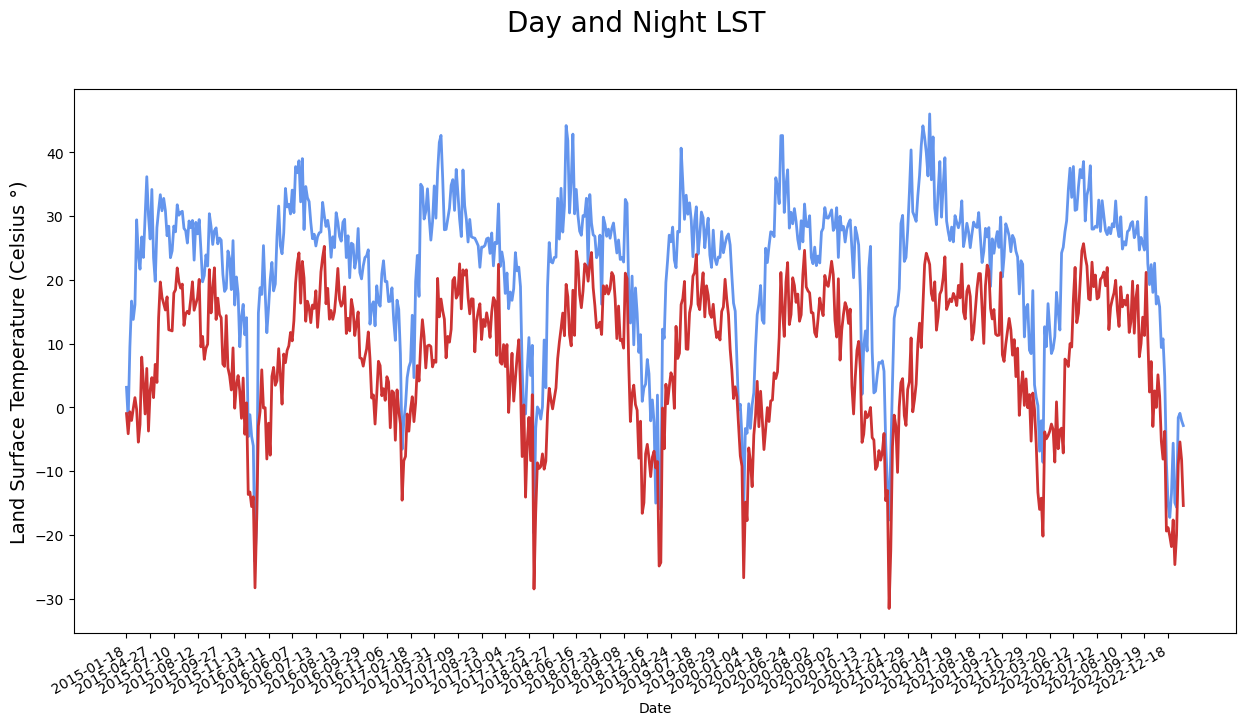

In [22]:
fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.plot(goodQual['Date'], goodQual['MOD11A1_061_LST_Day_1km'] - 273.15, color="#6495ED", lw=2)
ax1.plot(goodQual['Date'], goodQual['MOD11A1_061_LST_Night_1km'] - 273.15, color="#CD3333", lw=2)

ax1.set_xlabel("Date")
ax1.set_ylabel("Land Surface Temperature (Celsius °)", fontsize=14)

ax1.set_xticks (goodQual['Date'][::14]) # print pone label for every 14 obs 

fig.suptitle("Day and Night LST", fontsize=20)
fig.autofmt_xdate()

## Contact Info:  

Email: LPDAAC@usgs.gov  
Voice: +1-866-573-3222  
Organization: Land Processes Distributed Active Archive Center (LP DAAC)¹  
Website: <https://lpdaac.usgs.gov/>  
Date last modified: 05-06-2023  

¹Work performed under USGS contract G15PD00467 for NASA contract NNG14HH33I.  